In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
from pathlib import Path
import re

Read data

In [5]:
SET = 4

pseudo = pd.read_csv('test.csv')
pseudo = pseudo[pseudo['set'] == SET]

subfolders = sorted([p.name for p in Path("./data").iterdir() if p.is_dir()])

data_all = []
history_all = []

for folder in subfolders:
    data_all.append(pd.read_parquet(f'./data/{folder}/sample/set_{SET}.parquet'))
    history_all.append(pd.read_parquet(f'./data/{folder}/history/set_{SET}.parquet'))

def make_title(name):
    n = re.findall(r"\d+", name)
    n = [int(x) for x in n]
    if n[1]==1:
        l= 'MAE'
    elif n[1]==2:
        l= 'MSE'
    return f'Batch Size: {n[0]}; Loss: {l}; CFFs: {n[2]}', n[2]

Model Loss and cross section plot

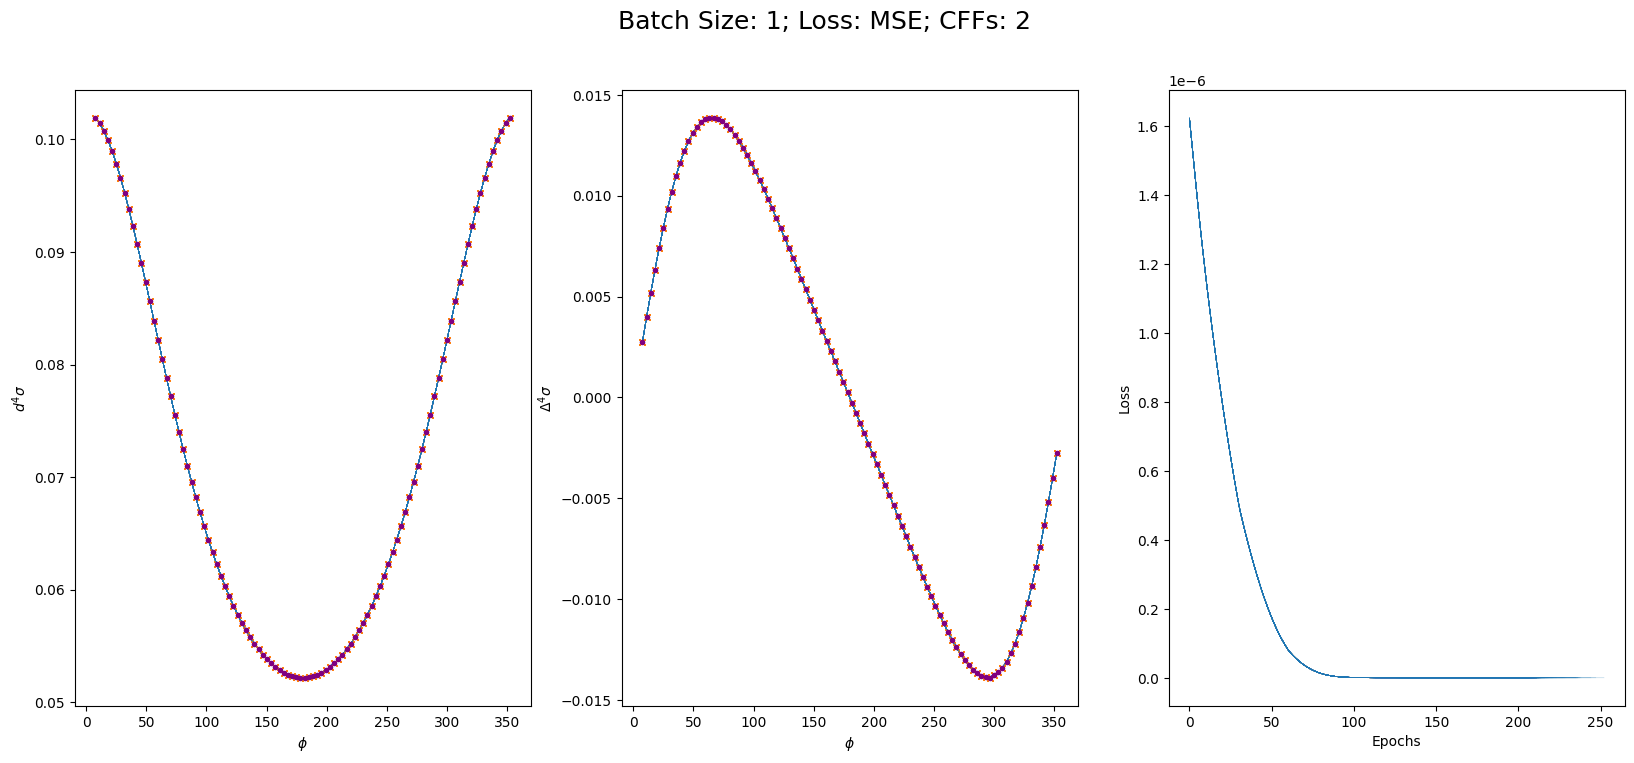

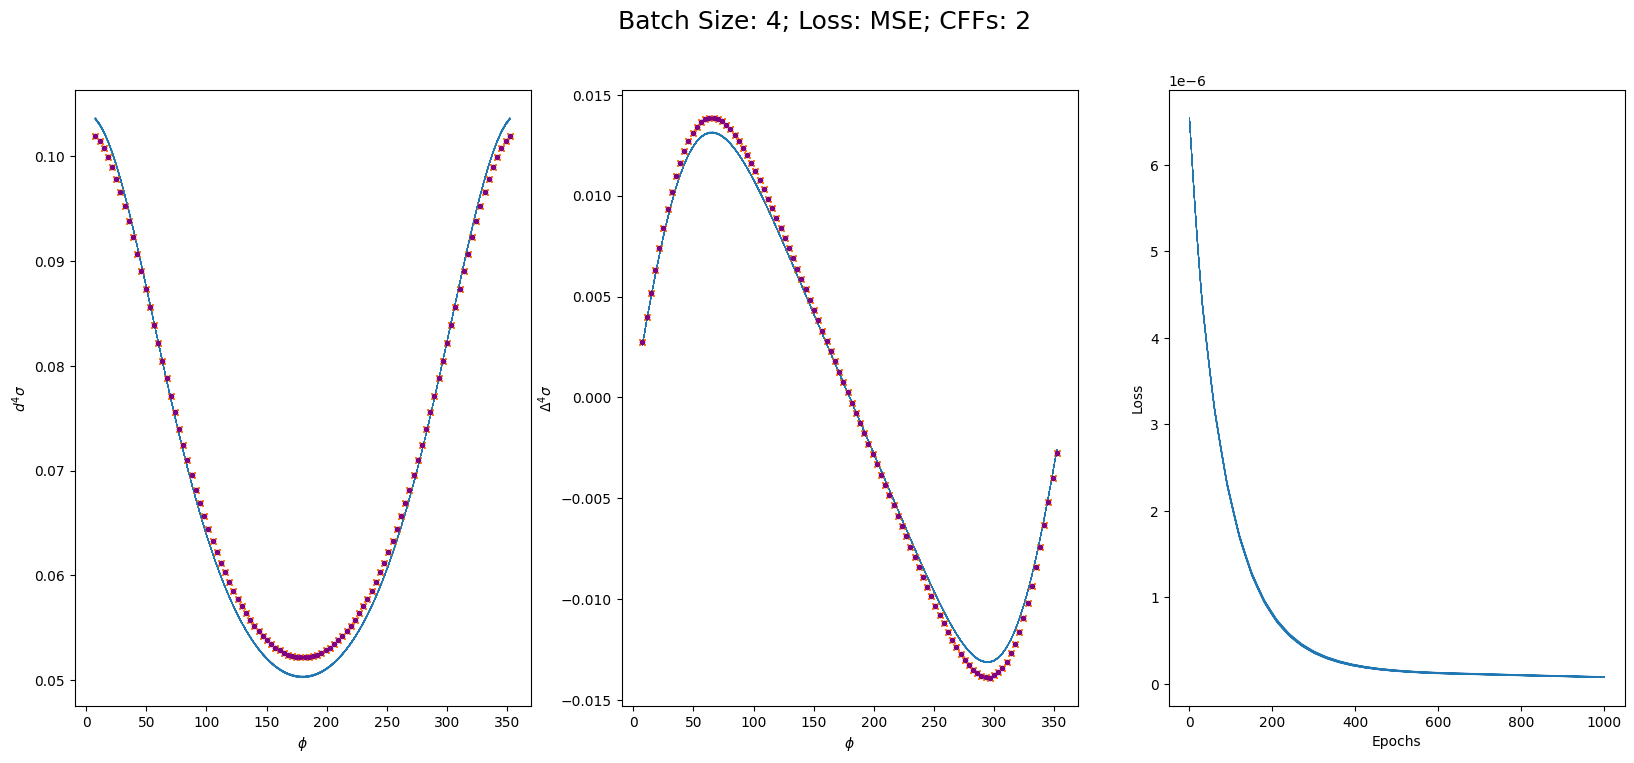

In [6]:
def cs_loss_plot(i, dataset, historyset):

    fig, ax = plt.subplots(1, 3, figsize=(20,8))
    fig.suptitle(make_title(subfolders[i])[0], size=18)

    for replica, data in dataset.groupby('replica'):
        
        ax[0].plot(data['phi'], data['dsig_fit'], c='tab:blue', lw=0.5, alpha=0.3)
        ax[0].plot(data['phi'], data['dsig_sample'], 'x', c='tab:orange', alpha=0.2, ms=4)

        ax[1].plot(data['phi'], data['delsig_fit'], c='tab:blue', lw=0.5, alpha=0.3)
        ax[1].plot(data['phi'], data['delsig_sample'], 'x', c='tab:orange', alpha=0.2, ms=4)

    ax[0].errorbar(pseudo['phi'], pseudo['dsig'], pseudo['dsig_err'], fmt='.', c='purple')
    ax[1].errorbar(pseudo['phi'], pseudo['delsig'], pseudo['delsig_err'], fmt='.', c='purple')

    ax[0].set_xlabel(r'$\phi$')
    ax[0].set_ylabel(r'$d^4\sigma$')

    ax[1].set_xlabel(r'$\phi$')
    ax[1].set_ylabel(r'$\Delta^4\sigma$')

    for replica, history in historyset.groupby('replica'):
        epoch = np.arange(len(history))
        ax[2].plot(epoch, history['loss'], c='tab:blue', lw=0.5, alpha=0.3)

    ax[2].set_xlabel('Epochs')
    ax[2].set_ylabel('Loss');
    ax[2].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

for i in range(len(data_all)):
    cs_loss_plot(i, data_all[i], history_all[i])

CFF Plots

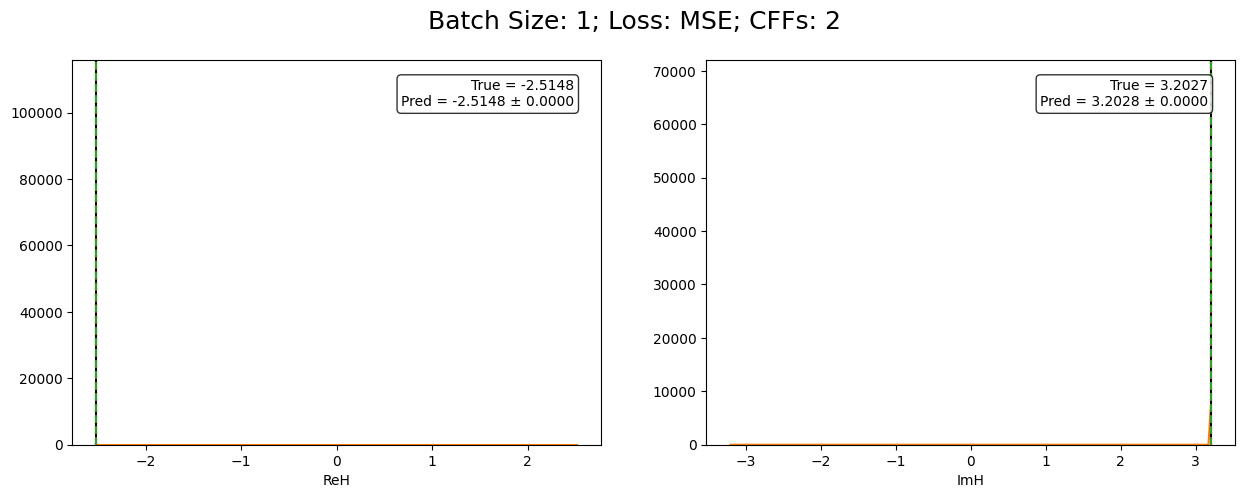

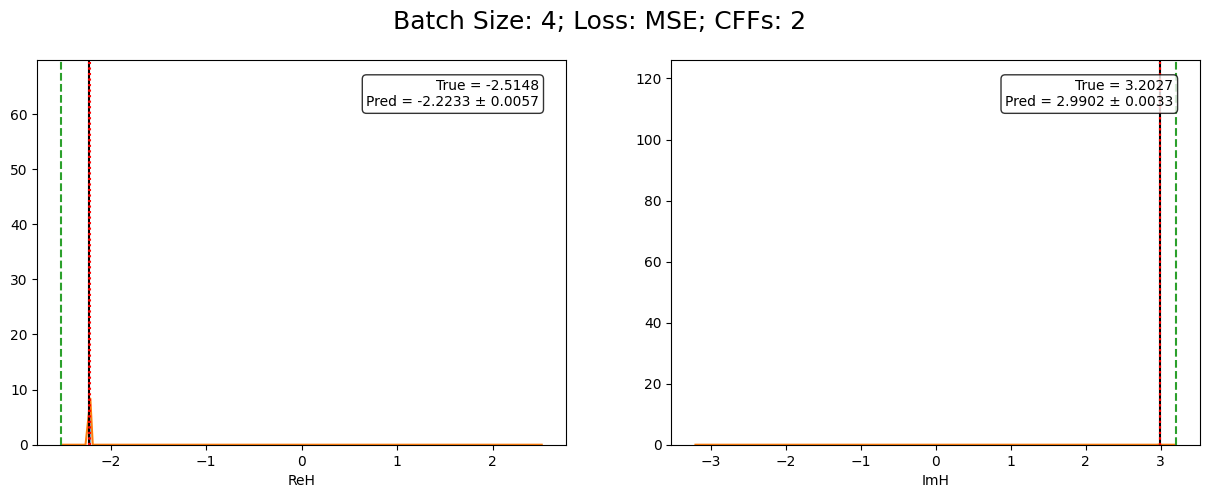

In [7]:
def cffs_plot(i, data):

    names = ["ReH","ImH","ReHt","ImHt","ReE","ReEt","ImE","ImEt"]
    title, num_cffs = make_title(subfolders[i])
    fig, ax = plt.subplots(int(np.ceil(num_cffs/2)), 2, figsize=(15,5*np.ceil(num_cffs/2)))
    fig.suptitle(title, size=18)
    
    ax = ax.flatten()
    i = 0
    
    for name in names:

        pred = data[name+'_pred'].unique()
        if len(pred)==1:
            continue
        
        true = pseudo[name].unique()[0]
        mu, sigma = norm.fit(pred)
        ax[i].hist(pred, bins=10, density=True, alpha=0.6)

        x = np.linspace(min(min(pred), -abs(true)), max(max(pred), abs(true)), 200)
        pdf = norm.pdf(x, mu, sigma)
        ax[i].plot(x, pdf)
        ax[i].axvline(mu, c='k')
        ax[i].axvline(mu + sigma, ls=':', c='r')
        ax[i].axvline(mu - sigma, ls=':', c='r')
        ax[i].axvline(true, ls='--', c='tab:green')

        ax[i].text(
            0.95, 0.95,
            f"True = {true:.4f}\nPred = {mu:.4f} ± {sigma:.4f}",
            transform=ax[i].transAxes,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        ax[i].set_xlabel(name) 

        i+=1

for i in range(len(data_all)):
    cffs_plot(i, data_all[i])